In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#import sys
#sys.path.insert(0,"../src/")

from FrankeFunction import FrankeFunction
from linear_regression import *
from bootstrap import *
from cross_validation import *
from stat_tools import *
import unit_tests

%matplotlib inline

In [2]:
# Make sure things are working as expected
unit_tests.OLS_unit_test()
unit_tests.OLS_SVD_unit_test()
unit_tests.Ridge_unit_test()

# Problem 1a)

- Play around with the franke funtion both with & without noise!
- Perform OLS up to 5th order
- Compute R2
- Compute MSE
- Find confidence interval of beta

In [3]:
# Generate test data
n = 300 # Number of data points

x_dat = np.random.uniform(0, 1, n)
y_dat = np.random.uniform(0, 1, n)
z_dat = FrankeFunction(x_dat, y_dat)

# Set up the scaler
scaler = StandardScaler()

In [4]:


# Wrap the analysis in a function to duplicate for Clean & Noisy data
def p1_analysis(x, y, z, degrees):
    
    mse = pd.DataFrame(columns=["train", "test"], index = degrees)
    r2 = pd.DataFrame(columns=["train", "test"], index = degrees)

    #var_b = pd.DataFrame(indices=degrees)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])

        beta = OLS_SVD(X_train, z_train)
        
        mse["train"][i] = MSE(z_train, X_train @ beta)
        mse["test"][i] = MSE(z_test, X_test @ beta)

        r2["train"][i] = R2(z_train, X_train @ beta)
        r2["test"][i] = R2(z_test, X_test @ beta)

        #var_b.append([deg, var_beta(z_train, X_train)])
        
    return mse, r2, 0#, var_b

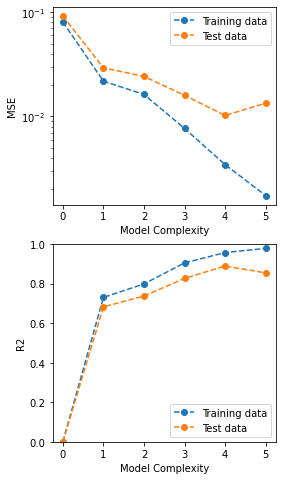

In [5]:
degrees = np.arange(0, 6) # Degrees of the polynomial

# Generate data
MSE_clean, R2_clean, var_b_clean = p1_analysis(x_dat, y_dat, z_dat, degrees)

plt.figure(figsize=(4,8))
plt.tight_layout()
# Plot MSE
plt.subplot(211)
plt.semilogy(degrees, MSE_clean["train"],"o--", label = "Training data")
plt.semilogy(degrees, MSE_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
# Plot R2
plt.subplot(212)
plt.plot(degrees, R2_clean["train"],"o--", label = "Training data")
plt.plot(degrees, R2_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.ylim([0,1])
plt.legend()

How does the model respond to noise?

[]

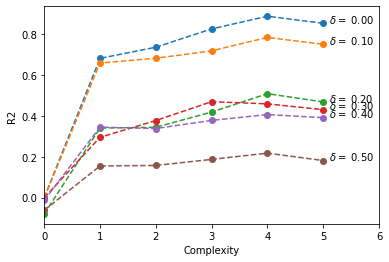

In [6]:
noises = np.linspace(0, .5, 6)
degrees = np.arange(0, 6)

for noise in noises:
    # Generate a new noisy dataset
    z_dat_noisy = z_dat + np.random.normal(0, 1, n) * noise
    MSE_noisy, R2_noisy, var_b_noisy = p1_analysis(x_dat, y_dat, z_dat_noisy,degrees)
    
    plt.plot(degrees, R2_noisy["test"], "o--")
    plt.annotate("$\delta=$ %.2f" % noise, [degrees[-1] + .1,R2_noisy["test"].iloc[-1]])

plt.xlim([0, degrees[-1] + 1])
plt.xlabel("Complexity")
plt.ylabel("R2")
plt.plot()

# Problem 1b)
- Replicate Fig 2.11 from Hastie et al using bootstrap
- Bias variance analysis

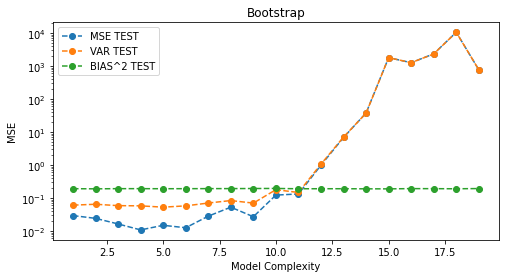

In [7]:
def bootstrap_analysis(x, y, z, degrees, N_bootstraps, regression=linear_regression.OLS_SVD):
    
    columns = [
        "MSE train",
        "MSE test",
        "R2 train",
        "R2 test",
        "Bias train",
        "Bias test",
        "Variance train",
        "Variance test",
    ]
    
    df = pd.DataFrame(columns=columns)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])
        
        output = bootstrap(
            X_train, 
            X_test, 
            z_train, 
            z_test,
            bootstraps = N_bootstraps,
            regression = regression
        )

        df = df.append(pd.DataFrame(output, index=[deg]))
    
    return df

degrees = np.arange(1, 20)
N_bootstraps = 100
data_bootstrap = bootstrap_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps)

plt.figure(figsize=(8,4))
degrees = np.arange(1, 20) 
#plt.semilogy(degrees, data_bootstrap["MSE train"],"o--", label = "MSE TRAIN")
plt.semilogy(degrees, data_bootstrap["MSE test"],"o--", label = "MSE TEST")
plt.semilogy(degrees, data_bootstrap["Variance test"],"o--", label = "VAR TEST")
#plt.semilogy(degrees, data_bootstrap["Variance train"],"o--", label = "VAR TRAIN")
plt.semilogy(degrees, data_bootstrap["Bias test"],"o--", label = "BIAS^2 TEST")
#plt.semilogy(degrees, data_bootstrap["Bias train"],"o--", label = "BIAS^2 TEST")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Bootstrap")
plt.legend(loc="best")

In [8]:
data_bootstrap

,MSE train,MSE test,R2 train,R2 test,Bias train,Bias test,Variance train,Variance test
1,2.138940e-02,0.029624,0.735380,0.678978,0.193189,0.193189,0.059106,0.061292
2,1.577072e-02,0.024440,0.803106,0.735158,0.191323,0.191323,0.063947,0.065287
3,7.365016e-03,0.016529,0.909081,0.820884,0.193676,0.193676,0.073333,0.059295
4,3.141123e-03,0.010906,0.961239,0.881817,0.193667,0.193667,0.077554,0.058373
5,1.516884e-03,0.015045,0.981184,0.836967,0.192780,0.192780,0.078808,0.053301
6,7.779799e-04,0.012689,0.990386,0.862493,0.193471,0.193471,0.079835,0.058332
7,3.126936e-04,0.028462,0.996152,0.691572,0.194087,0.194087,0.080557,0.071063
8,1.892460e-04,0.053268,0.997672,0.422763,0.194496,0.194496,0.080851,0.084460
9,8.785390e-05,0.027360,0.998928,0.703517,0.195590,0.195590,0.081408,0.070721
10,3.567794e-05,0.123694,0.999567,-0.340410,0.196682,0.196682,0.081915,0.180061


# Problem 1c)
- Do cross validation on the dataset. Compare MSE with bootstrap

In [9]:
def p3_analysis(x, y, z, degrees, k):
    
    columns = [
        "MSE train", "MSE test",
        "R2 train", "R2 test"
    ]
    
    df = pd.DataFrame(columns=columns)
    
    for i, deg in enumerate(degrees):
        X = design_matrix(x, y, deg)
    
        # Normalize the design matrix
        X = scaler.fit_transform(X)
        X[:, 0] = np.ones(X.shape[0])
        
        output = cross_validation(X, z, k_folds = k, regression=linear_regression.OLS_SVD)
        
        df = df.append(pd.DataFrame(output, index=[deg]))
        
        
    return df

In [10]:
degrees = np.arange(1, 16)
dat_cross = p3_analysis(x_dat, y_dat, z_dat, degrees, k=55)

dat_cross

,MSE train,MSE test,R2 train,R2 test
1,0.023291,0.024432,0.719804,0.480987
2,0.017079,0.017891,0.794538,0.592006
3,0.008080,0.009024,0.902799,0.772827
4,0.003734,0.004404,0.955069,0.861218
5,0.001857,0.002297,0.977663,0.927947
6,0.001075,0.001842,0.987065,0.936949
7,0.000512,0.001146,0.993841,0.969001
8,0.000299,0.000722,0.996400,0.954587
9,0.000165,0.001334,0.998010,0.864555
10,0.000085,0.000621,0.998981,0.979790


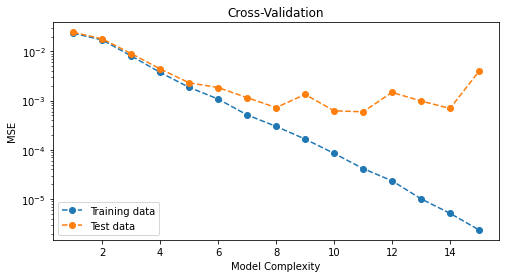

In [11]:
plt.figure(figsize=(8,4))

plt.semilogy(degrees, dat_cross["MSE train"],"o--", label = "Training data")
plt.semilogy(degrees, dat_cross["MSE test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

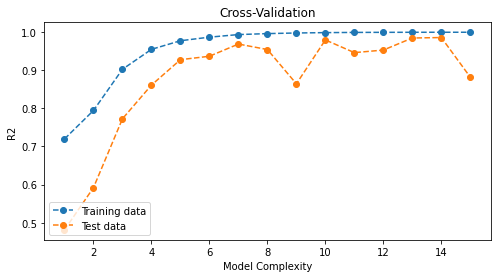

In [12]:
plt.figure(figsize=(8,4))

plt.plot(degrees, dat_cross["R2 train"],"o--", label = "Training data")
plt.plot(degrees, dat_cross["R2 test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

# Problem 1d)
- Do same analysis, but with Ridge regression

In [14]:
lambdas = np.logspace(-3, 0, 10)

for lamb in lambdas:
    degrees = np.arange(1, 20)
    N_bootstraps = 100
    data_bootstrap = bootstrap_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps, regression = lambda X, z : stat_tools.Ridge(X, z, lamb = lamb))

    #plt.semilogy(degrees, data_bootstrap["MSE train"],"o--", label = "MSE TRAIN")
    plt.semilogy(degrees, data_bootstrap["MSE test"],"o--", label = "MSE TEST")
    plt.semilogy(degrees, data_bootstrap["Variance test"],"o--", label = "VAR TEST")
    #plt.semilogy(degrees, data_bootstrap["Variance train"],"o--", label = "VAR TRAIN")
    plt.semilogy(degrees, data_bootstrap["Bias test"],"o--", label = "BIAS^2 TEST")
    #plt.semilogy(degrees, data_bootstrap["Bias train"],"o--", label = "BIAS^2 TEST")
    plt.xlabel("Model Complexity")
    plt.ylabel("MSE")
    plt.title("Bootstrap")
    plt.legend(loc="best")

AttributeError: module 'stat_tools' has no attribute 'Ridge'

# Problem 1e)
- Do Same analysis, but with Lasso Regression

# Problem 1f)
- Download real data!

# Problem 1d)
= Analyse real data using wisdom gained from Franke Function!

In [13]:
def k_fold_split(X, z, k_folds = 5):
    perm = np.random.permutation(len(z))
    perm = np.split(perm, k_folds)
    return perm

X =  np.ones([5, 5])
z = np.ones([5])
for i in range(5):
    X[i] *= i
    z[i] *= i